# Q1.1.1

In [13]:
# Import the necessary libraries
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy.stats as stats
from scipy.io import loadmat
from scipy.optimize import minimize
from scipy.special import expit, logit

In [14]:
# Load in the diffusion MRI data set
dwis = loadmat('data.mat')['dwis']
dwis = np.double(dwis)
dwis = dwis.transpose((3, 0, 1, 2))
[Dc, Dx, Dy, Dz] = dwis.shape
print(dwis.shape)

(108, 145, 174, 145)


In [15]:
# And the settings for each component image
qhat = np.loadtxt("bvecs", delimiter = " ").T
bvals = 1000 * np.sum(qhat * qhat, axis=1)
print(qhat.shape, bvals.shape)

(108, 3) (108,)


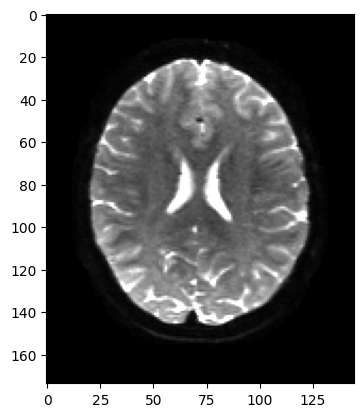

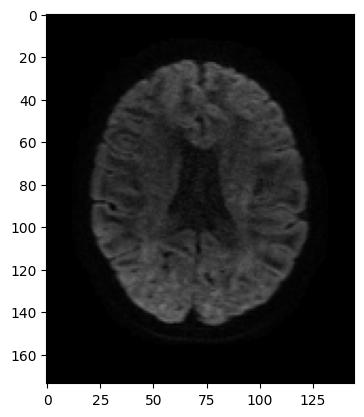

In [16]:
# Look at a single slice in a few channels
for i in range(0,2):
    plt.figure()
    plt.imshow(np.flipud(dwis[i,:,:,71].T),cmap='gray',vmax=10000)
    plt.show()

In [17]:
# Solve for x in log(A) = Gx - where x has all unknowns
x = np.zeros((145, 174, 7))
quadratic_matrix = -bvals * np.array([qhat[:,0]**2, 2*qhat[:,0]*qhat[:,1], 2*qhat[:,0]*qhat[:,2], qhat[:,1]**2, 2*qhat[:,1]*qhat[:,2], qhat[:,2]**2])
G = np.concatenate([np.ones((108,1)), quadratic_matrix.T], axis=1)

for i in range(145):
    for j in range(174):
        A = dwis[:,i,j,71]
        if np.min(A) > 0:
            W = np.diag(A**2)
            invmap = np.linalg.pinv(G.T @ W @ G) @ G.T @ W
            x[i,j,:] = invmap @ np.log(A)

D = np.zeros((145,174,3,3))
for i in range(145):
    for j in range(174):
        Dxx = x[i,j,1]
        Dxy = x[i,j,2]
        Dxz = x[i,j,3]
        Dyy = x[i,j,4]
        Dyz = x[i,j,5]
        Dzz = x[i,j,6]
        D[i,j] = np.array(
            [[Dxx, Dxy, Dxz],
             [Dxy, Dyy, Dyz],
             [Dxz, Dyz, Dzz]]
        )



In [18]:
# Calculate mean diffusivity
mean_D = np.zeros((145,174))

for i in range(145):
    for j in range(174):
        mean_D[i,j] = np.trace(D[i,j]) / 3

# Calculate FA
FA = np.zeros((145,174))
eig_val_D = np.zeros(((145,174,3)))
eig_vec_D = np.zeros((145,174,3,3))

for i in range(145):
    for j in range(174):
        eig_val, eig_vec = np.linalg.eig(np.squeeze(D[i,j]))
        eig_vec_D[i,j,:,:] = eig_vec
        eig_val_D[i,j,:] = eig_val
        if eig_val.sum() > 0:
            FA[i,j] = np.sqrt(1.5 * np.sum((eig_val - eig_val.mean())**2) / (eig_val**2).sum())

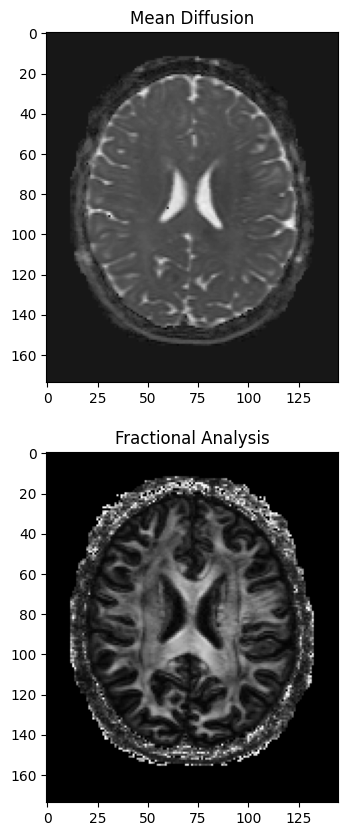

In [19]:
# plot FA
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].imshow(np.flipud(mean_D.T), cmap='gray')
axs[0].set_title('Mean Diffusion')

axs[1].imshow(np.flipud(FA.T), cmap='gray')
axs[1].set_title('Fractional Analysis')

# Show the plot
plt.show()


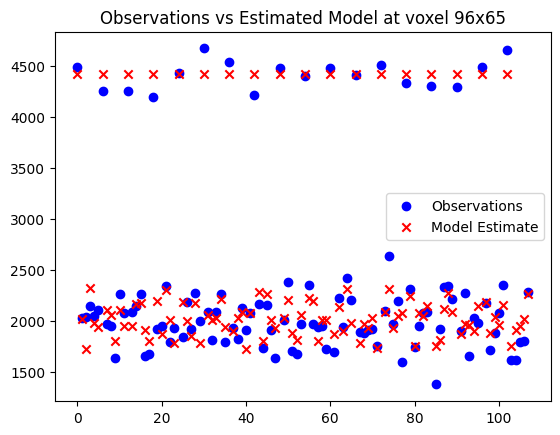

In [20]:
# Plot the model estimate against the measure signal at voxel 96,65 across all slices

A_est = np.exp(G @ np.squeeze(x[95,64,:]).reshape((-1,1)))
A_exact = np.squeeze(dwis[:,95,64,71])
# Create grid of subplots
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title('Observations vs Estimated Model at voxel 96x65')
plt.show()

<function numpy.transpose(a, axes=None)>

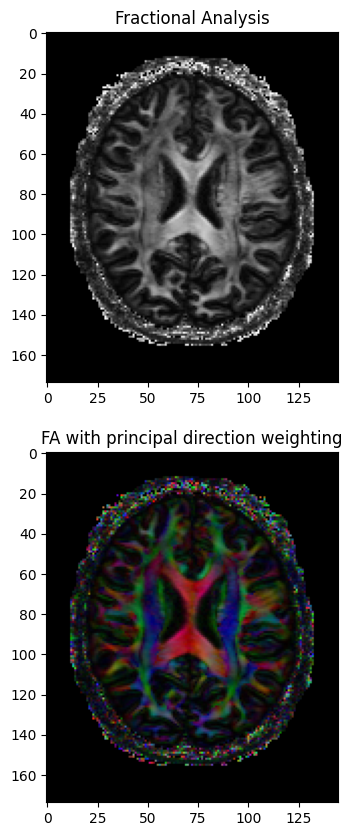

In [21]:
# Plot the FA weighted with eigenvalues on RBG spectrum
FA_RGB = np.zeros((145,174,3))

for i in range(145):
    for j in range(174):
        principal_eig_idx = np.argmax(np.abs(eig_val_D[i,j]))
        if eig_val_D[i,j,principal_eig_idx] > 0:
            eig_vec = eig_vec_D[i,j,:,principal_eig_idx]
            FA_RGB[i,j,:] = FA[i,j] * np.abs(np.array([eig_vec[0], eig_vec[1], eig_vec[2]]))

# normalise RGB values
FA_RGB = FA_RGB / np.max(FA_RGB)

# print to screen FA_RGB
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].imshow(np.flipud(FA.T), cmap='gray')
axs[0].set_title('Fractional Analysis')

axs[1].imshow(np.flipud(np.transpose(FA_RGB, (1,0,2))))
axs[1].set_title('FA with principal direction weighting')

np.transpose


# Q1.1.2
### Ball and Stick Model

In [22]:
def ball_stick(x):
    # Behrens et al, 2003
    # Characterization and Propagation of Uncertainty in Diffusion-Weighted MR Imaging
    # https://doi.org/10.1002/mrm.10609
    
    # Extract the parameters
    # diff: diffusion
    # f: fraction of signal contributed by diffusion tensor along fiber direction theta, phi
    S0, diff, f, theta, phi = x
    
    # Fiber direction
    fibdir = np.array([
        np.cos(phi) * np.sin(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(theta),
    ])
    
    # creates a 2D array of fibdir stacked ontop of each other len(bvals) times
    # so now has the dimensions [len(bvals)x3]
    tile = np.tile(fibdir, (len(bvals), 1))
    fibdotgrad = np.sum(qhat * tile, axis=1)
    
    S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
    return S


def BallStickSSD(x, voxel):
    S = ball_stick(x)
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)

In [23]:
# Use minimize for non-linear estimation of the ball-and-stick parameters
# The first starting point finds a spurious local min; the second
# a more reasonable min.
avox = dwis[:,91,64,71]
#startx = np.array([3500, -5e-6, 120, 0, 0])
#startx = np.array([4200, 4e-4, 0.25, 0, 0])
# start given by moodle note:
startx = np.array([3300, 1.0e-03, 4.5e-01, 1.0, 1.0])
results = minimize(
    fun=BallStickSSD,
    x0=startx,
    args=(avox,),
)

results

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8280\2916082994.py:23: RuntimeWarning: overflow encountered in exp
  S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
c:\Users\fl_cl\miniconda3\envs\MV00-py3.9\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8280\2916082994.py:23: RuntimeWarning: overflow encountered in exp
  S = S0 * (f * np.exp(-bvals * diff * (fibdotgrad**2)) + (1-f) * np.exp(-bvals * diff))
C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8280\2916082994.py:30: RuntimeWarning: overflow encountered in square
  return np.sum((voxel - S) ** 2)


      fun: 54806552.90143531
 hess_inv: array([[1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1]])
      jac: array([-4.47215000e+04,  4.98960658e+10,  1.76876395e+07, -1.44313685e+07,
        1.24521480e+07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 30
      nit: 0
     njev: 3
   status: 2
  success: False
        x: array([3.3e+03, 1.0e-03, 4.5e-01, 1.0e+00, 1.0e+00])

error mean: -318.7261807778814
error std: 640.0585840856426
estimated SS: 44244899.0346655, calculated SS: 54806552.90143531, diff: -10561653.866769806


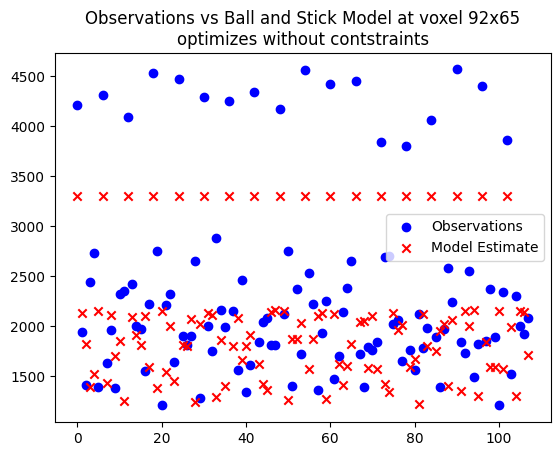

In [24]:
# Use the fitted parameters to get estimated values
A_est = ball_stick(results['x'])
A_exact = np.squeeze(dwis[:,91,64,71])

# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean}")
print(f"error std: {np.sqrt(error_var)}")

# Use the standard deviation to calculate the estimated Sum of Squares diff
ss_est = 108 * error_var
ss_exact = results['fun']
print(f"estimated SS: {ss_est}, calculated SS: {ss_exact}, diff: {ss_est - ss_exact}")

# Create grid of subplots to compare
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title('Observations vs Ball and Stick Model at voxel 92x65\noptimizes without contstraints')
plt.show()

In [25]:
# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean}")
print(f"error std: {np.sqrt(error_var)}")

# Use the standard deviation to calculate the estimated Sum of Squares diff
ss_est = 108 * error_var
ss_exact = results['fun']
print(f"estimated SS: {ss_est}, calculated SS: {ss_exact}, diff: {ss_est - ss_exact}")

error mean: -318.7261807778814
error std: 640.0585840856426
estimated SS: 44244899.0346655, calculated SS: 54806552.90143531, diff: -10561653.866769806


# Q1.1.3

In [26]:
# We are now constraining the parameters (S0, diff >0, f in (0,1), theta, phi in (0,2pi))
# We do this by transforming x to be squared, or expit() and scaled to ensure they are in the 
# correct domain. Because the transformation happens after the optimizer guesses x_t+1 we
# have to transform the optimized solution to get the correct fitted parameters

# Given S0, diff, f, theta and phi - we transform to constrain it
def transform(x):
    """
    so = x[0]
    diff = x[1]
    f = x[2]
    theta = x[3]
    phi = x[4]
    """
    return [x[0]**2, x[1]**2, expit(x[2]), expit(x[3])*np.pi, expit(x[4])*2*np.pi]

# Given transformed x return parameters we are looking for
def transform_inv(x):
    """
    so**2 = x[0]
    diff**2 = x[1]
    expit(f) = x[2]
    pi*expit(theta) = x[3]
    2*pi*expit(phi) = x[4]
    """
    return [x[0]**0.5, x[1]**0.5, logit(x[2]), logit(x[3]/(np.pi)), logit(x[4]/(2*np.pi))]

def BallStickSSD_constrained(x, voxel):
    S = ball_stick(transform(x))
    # Compute sum of square differences
    return np.sum((voxel - S) ** 2)


In [27]:
# Use the transform to find the parameters constrained
results = minimize(
    fun=BallStickSSD_constrained,
    x0=transform_inv(startx),
    args=(avox,),
)

results

# With constraints the fitting works and we get sensible results (S0, diff >0, etc.)
# and plotting against observed values we get much better results

      fun: 5871996.800798102
 hess_inv: array([[ 2.20165758e-05, -4.17141458e-08,  5.44591774e-06,
         4.70446133e-06,  5.50197618e-06],
       [-4.17141458e-08,  8.06144786e-11, -1.04697159e-08,
        -8.87274028e-09, -1.03730058e-08],
       [ 5.44591774e-06, -1.04697159e-08,  1.38064626e-06,
         1.15553132e-06,  1.34915466e-06],
       [ 4.70446133e-06, -8.87274028e-09,  1.15553132e-06,
         1.01518555e-06,  1.19411094e-06],
       [ 5.50197618e-06, -1.03730058e-08,  1.34915466e-06,
         1.19411094e-06,  1.47570995e-06]])
      jac: array([ 0.1875,  5.3125, -0.125 , -0.3125,  0.0625])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 448
      nit: 32
     njev: 73
   status: 2
  success: False
        x: array([ 6.52527790e+01, -3.37830607e-02, -5.87056279e-01,  7.89459938e-01,
       -2.28680659e+00])

In [36]:
# Use the transform to find the parameters constrained
results = minimize(
    fun=BallStickSSD_constrained,
    x0=transform_inv(startx),
    args=(dwis[:,14,63,71]),
)

results

# With constraints the fitting works and we get sensible results (S0, diff >0, etc.)
# and plotting against observed values we get much better results

      fun: 2548029.969065578
 hess_inv: array([[ 1.58165580e-05,  1.88640747e-07,  2.74610715e-05,
        -2.90110009e-05, -1.94730041e-06],
       [ 1.88640747e-07,  2.87554143e-05,  4.86304109e-03,
        -2.12775213e-03, -7.54193934e-04],
       [ 2.74610715e-05,  4.86304109e-03,  8.22467215e-01,
        -3.61850522e-01, -1.21610712e-01],
       [-2.90110009e-05, -2.12775213e-03, -3.61850522e-01,
         2.60681261e-01, -2.48435694e-01],
       [-1.94730041e-06, -7.54193934e-04, -1.21610712e-01,
        -2.48435694e-01,  9.16525143e-01]])
      jac: array([0., 0., 0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 8
     njev: 16
   status: 0
  success: True
        x: array([-20.65565663,   0.76945661, -28.48971825,  46.28995845,
         4.09476427])

error mean: 0.11698199288636496
error std: 234.26152257921527
estimated SS: 5926873.783802276, calculated SS: 5871996.800798102, diff: 54876.983004173264


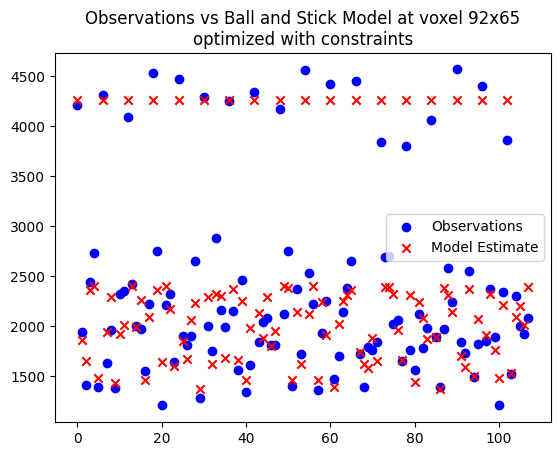

In [34]:
# Use the fitted parameters to get estimated values
#A_est = ball_stick(transform(results['x']))
#A_exact = np.squeeze(dwis[:,91,64,71])
A_est = ball_stick(transform(results['x']))
A_exact = np.squeeze(dwis[:,91,64,71])

# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean}")
print(f"error std: {np.sqrt(error_var)}")

# Use the standard deviation to calculate the estimated Sum of Squares diff
ss_est = 108 * error_var
ss_exact = results['fun']
print(f"estimated SS: {ss_est}, calculated SS: {ss_exact}, diff: {ss_est - ss_exact}")

# Create grid of subplots to compare
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title('Observations vs Ball and Stick Model at voxel 92x65\noptimized with constraints')
plt.show()

Sum of sqares has significantly reduced because now the model is fitting the observed data much better

# Q1.1.4

In [29]:
# for the same voxel run multiple times to try and find the best minimum
def BallStickSSD_constrained_findSSDmin(max_iter, startx, avox):
    # given parameters of a single avox, run max_iter times and find converged SSD each time
    # return all found solutions and SSD values
    
    noise_std = startx / 5
    num_parameters = startx.size
    X_single_voxel = np.zeros((max_iter, num_parameters))
    X_SSD = np.zeros(max_iter)

    for i in range(max_iter):
        # find some noise, add to the start, and transform and inverse it to make sure the 
        # peturbed start is a realistic start
        noise = np.random.normal(loc=np.zeros(num_parameters), scale=noise_std)
        x_i = startx + noise
        x_i = transform_inv(transform(x_i))
        results = minimize(
            fun=BallStickSSD_constrained,
            x0=transform_inv(x_i),
            args=(avox,),
        )
        X_single_voxel[i,:] = results['x']
        SSD_result = results['fun']
        if np.isnan(SSD_result):
            SSD_result = np.inf
        X_SSD[i] = SSD_result
    
    return X_single_voxel, X_SSD


def find_prob_finding_SSD_globalmin(startx, avox, max_iter=100, eps=1e-1):
    # given a voxex, and a starting position. Optimize to solve for x with 95% confidence the global minima has been found
    
    X_single_voxel, X_SSD = BallStickSSD_constrained_findSSDmin(max_iter, startx=startx, avox=avox)
    
    min_SSD = np.min(X_SSD)
    min_SSD_count = np.isclose(X_SSD, min_SSD, eps).sum()
    p = min_SSD_count / X_SSD.shape[0]
    print(f"min_SSD: {min_SSD}, prob_global_min = {p}")
    return p


def find_N_for_95percent_global_min(p):
    return int(np.ceil(np.log(0.05) / np.log(1-p)))

"""
so = x[0]
diff = x[1]
f = x[2]
theta = x[3]
phi = x[4]
"""

'\nso = x[0]\ndiff = x[1]\nf = x[2]\ntheta = x[3]\nphi = x[4]\n'

In [30]:
# Look at the results of X_SSD. See what the reoccurance of the min was (within some tolerance) and use that as a
# probability of hitting the min to get an estimate on howmany times we need to run it to be 95% sure
voxel_idxs = np.array([[91,64], [60,60], [55,55], [80,60], [85,55], [85, 72], [70, 70]])
N_array = np.zeros(shape=voxel_idxs.shape[0])

for i, voxel_idx in enumerate(voxel_idxs):
    p = find_prob_finding_SSD_globalmin(startx, dwis[:, voxel_idx[0], voxel_idx[1], 71], max_iter=100)
    N_array[i] = find_N_for_95percent_global_min(p)

print(f"Found Ns: {N_array}")
N = int(N_array.max())
print(f"Will use the max N found in our small sample: max_N = {N}")

min_SSD: 5871996.80073267, prob_global_min = 0.81
min_SSD: 3973422.184930423, prob_global_min = 0.98
min_SSD: 6565608.199824468, prob_global_min = 1.0


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8280\886908193.py:44: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


min_SSD: 3494706.812720848, prob_global_min = 0.79
min_SSD: 3234355.1259696353, prob_global_min = 0.31
min_SSD: 8882585.584172565, prob_global_min = 0.37
min_SSD: 4253463.44022563, prob_global_min = 1.0
Found Ns: [2. 1. 0. 2. 9. 7. 0.]
Will use the max N found in our small sample: max_N = 9


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_8280\886908193.py:44: RuntimeWarning: divide by zero encountered in log
  return int(np.ceil(np.log(0.05) / np.log(1-p)))


# Q1.1.5

In [31]:
# use the max N found across all voxels to find the global min

is_skip = True
file_path = "X_optimize_each_voxel_with_same_N.npy"

if not is_skip:
    X = np.zeros((145, 174, startx.size))
    X = np.load(file_path)

    for i in range(20, 145):
        for j in range(174):
            A = dwis[:,i,j,71]
            if np.min(A) > 0:
                x_single_voxel, x_SSD = BallStickSSD_constrained_findSSDmin(N, startx, dwis[:,i,j,71])
                min_idx = np.argmin(x_SSD)
                X[i,j,:] = transform(x_single_voxel[min_idx,:])
        # save each row to a file
        np.save(file_path, X)
        print(f"row {i} complete")
else:
    X = np.load(file_path)



In [32]:
idx = np.argmax(X[14,:,0])
X[14,idx]
idx

63

error mean: -0.01978829664985445
error std: 179.00867990500365
estimated SS: 3460763.6079838625, calculated SS: 5871996.800798102, diff: -2411233.1928142398


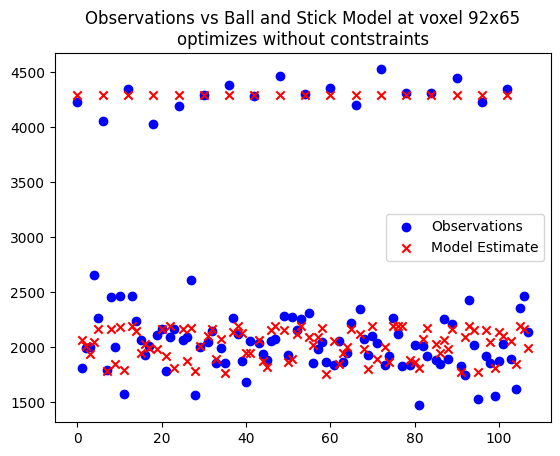

In [33]:
# Use the fitted parameters to get estimated values
idx = 65
jdx = 73
A_est = ball_stick(X[jdx,idx])
A_exact = np.squeeze(dwis[:,jdx,idx,71])

# Find the mean and std of the errors
error_dist = stats.describe(A_est - A_exact)
error_mean = error_dist[2]
error_var = error_dist[3]
print(f"error mean: {error_mean}")
print(f"error std: {np.sqrt(error_var)}")

# Use the standard deviation to calculate the estimated Sum of Squares diff
ss_est = 108 * error_var
ss_exact = results['fun']
print(f"estimated SS: {ss_est}, calculated SS: {ss_exact}, diff: {ss_est - ss_exact}")

# Create grid of subplots to compare
plt.scatter(np.arange(108), A_exact, marker='o', color='b', label='Observations')
plt.scatter(np.arange(108), A_est, marker='x', color='r', label='Model Estimate')
plt.legend()
plt.title('Observations vs Ball and Stick Model at voxel 92x65\noptimizes without contstraints')
plt.show()

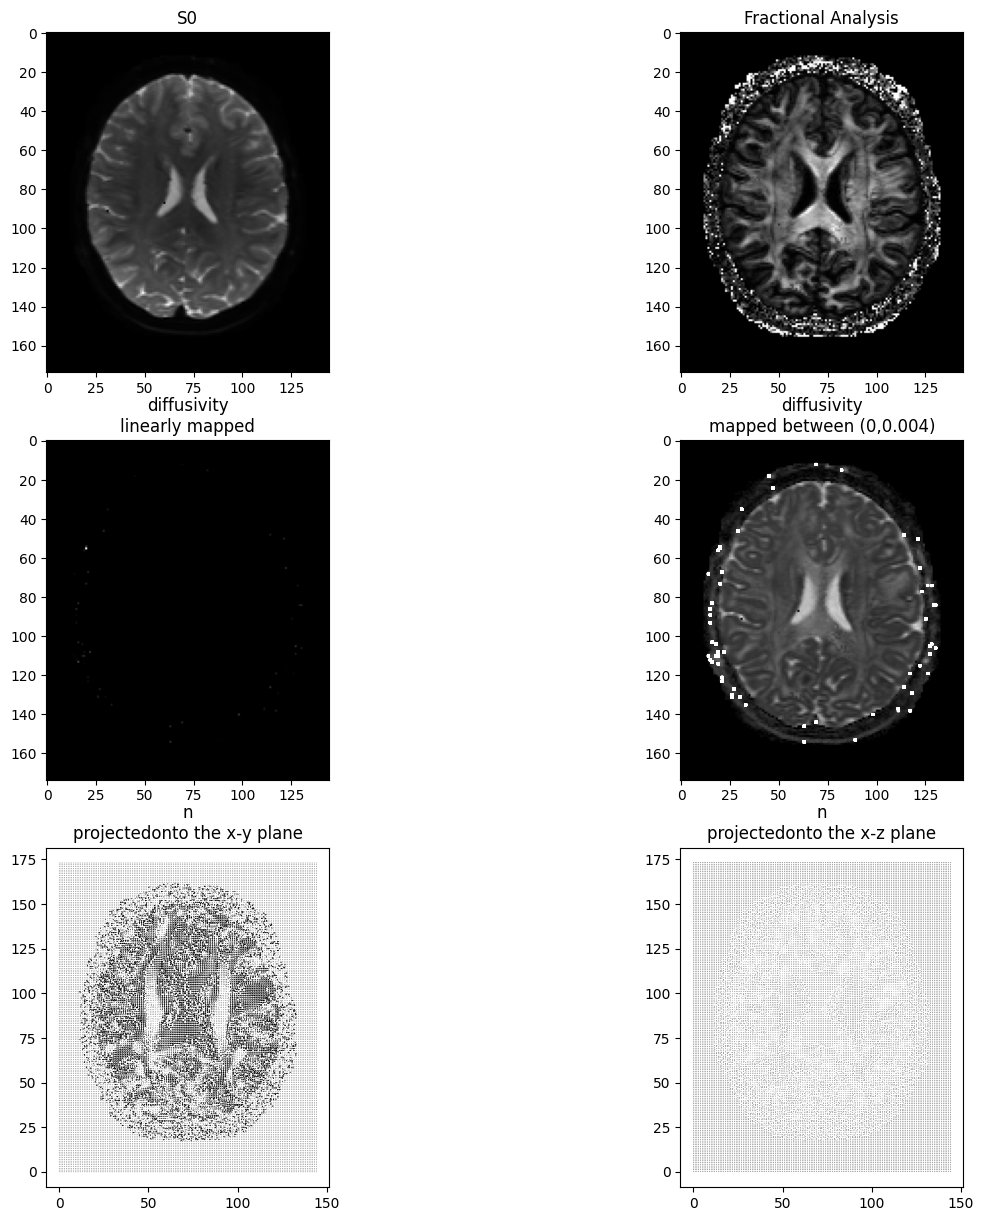

In [98]:
# plot the S0, d, f, and the RESNORM, and fibre direction of n
"""
so = x[0]
diff = x[1]
f = x[2]
theta = x[3]
phi = x[4]
"""

S0 = X[:,:,0]
d_raw = X[:,:,1]
d_processed = np.where(d_raw > 3, 0, d_raw)
f = X[:,:,2]
theta = X[:,:,3]
phi = X[:,:,4]

n_zplane_x = np.sin(theta) * np.cos(phi)
n_zplane_y = - np.sin(theta) * np.sin(phi)

n_yplane_x = np.sin(theta) * np.sin(phi)
n_yplane_y = np.cos(theta)


# plot FA
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(3,2, figsize=(15, 15))

axs[0,0].imshow(np.flipud(S0.T), cmap='gray')
axs[0,0].set_title('S0')

axs[0,1].imshow(np.flipud(f.T), cmap='gray')
axs[0,1].set_title('Fractional Analysis')

axs[1,0].imshow(np.flipud(d_raw.T), cmap='gray')
axs[1,0].set_title('diffusivity\nlinearly mapped')

axs[1,1].imshow(np.flipud(d_raw.T), cmap='gray', vmax=0.004)
axs[1,1].set_title('diffusivity\nmapped between (0,0.004)')

axs[2,0].quiver(n_zplane_x.T, n_zplane_y.T)
axs[2,0].set_title('n\nprojectedonto the x-y plane')
axs[2,0].set_aspect('equal')

axs[2,1].quiver(n_yplane_x.T, n_yplane_y.T)
axs[2,1].set_title('n\nprojectedonto the x-z plane')
axs[2,1].set_aspect('equal')

# Show the plot
plt.show()

In [96]:
stats.describe(n_zplane_y.flatten())

DescribeResult(nobs=25230, minmax=(-0.9998396553067574, 0.9987267843006918), mean=-0.12149984224886674, variance=0.13643528813231467, skewness=-0.33628974114413596, kurtosis=0.7948111133299003)